$\mathbf{Fast \ Fourier \ Transform}$ 

FFT transforms a signal from its time representation into the frequency domain by sampling data at fixed intervals and decomposing it into different frequencies. 

This algorithm recovers clusters by propagating waves through a graph. How does it use FFT on the local components. How does this work as a distributed system?


In [1]:
import numpy as np
from lib.spectral_clustering import similarity_matrix, laplacian_matrix, spectral_clustering
from lib.datasets import gaussian_mixture as gm
from lib.kmeans import kmeans
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib import cm
import scipy.fftpack
import scipy.signal

# Building Our Functions to Cluster with the Wave Equation

In [2]:
def array_to_binary(row):
    '''
    This function takes a row of 0's and 1's and turns it into binary, 
    backwards, so [0, 0, 1] becomes 4 
    '''
    binary_to_decimal = 0
    for i in range(len(row)):
        binary_to_decimal += row[i] * 2 ** i
    return binary_to_decimal

def cluster_wave_eq(k, T_max, num_nodes, c, normalized_laplacian):
    '''
    k = number of eigenvectors used, maybe??? < 2**k clusters
    T_max = number of iterations in time
    num_nodes = number of nodes in our graph
    c = constant in the wave equation. 0 < c < sqrt(2) for stability
    normalized_laplacian = D**{-1}L
    '''
    # initialize heat matrix: each row corresponds to a node, column corresponds to a step in time
    heat = np.zeros(shape = (num_nodes, T_max + 1)) #offset index by 1 because we need index -1, evolves with time
    #print(heat.shape)
    heat[:, 0] = np.random.uniform(size = num_nodes)
    heat[:, 1] = heat[:, 0] 
    #print(heat[:, 1].shape)
    # populate the heat matrix
    for i in range(2, T_max + 1): 
        heat[:, i] = 2 * heat[:, i-1] - heat[:, i-2] - (c ** 2) * (normalized_laplacian @ heat[:, i-1])
    # calculate FFT for each node, the nth entry corresponds to e^(2pi ni/N) and encodes amplitude and phase shift
    heat_fft = np.fft.fft(heat, axis=1)
    # Finds the index of the k largest power over each row
    indices = [sp.signal.find_peaks(heat_fft[j, :])[:k] for j in range(len(heat_fft))]
    eigenvector = np.zeros(shape = (num_nodes, k))
    binary = np.zeros(shape = (num_nodes, k))
    for i in range(num_nodes): # for each row, ie each node
        for j in range(k-1): # find the jth largest frequency
            eigenvector[i][j] = np.real(heat_fft[i][j])
            if eigenvector[i][j] > 0:
                binary[i][j] = 1
            else:
                binary[i][j] = 0
    cluster_num = [array_to_binary(binary[i]) for i in range(num_nodes)]
    return cluster_num


# Generating Data

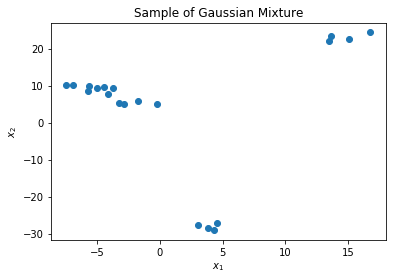

In [4]:
n_gaussians = 5
n_pts = 4
n = n_pts * n_gaussians
d = 2

data = gm(n_gaussians, n_pts, d, centroid_var=10)

plt.scatter(*data.T)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Sample of Gaussian Mixture")
plt.show()

# Standard Graph Spectral Clustering

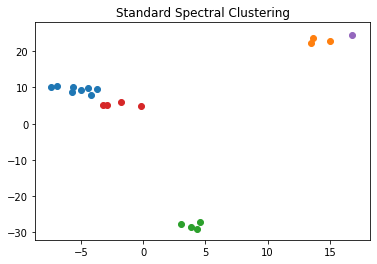

In [5]:
spectral = spectral_clustering(data, k=n_gaussians, lform="rw", metric = "g", s=1)
for i in range(len(spectral)):
    d = data[spectral == i].T
    x = d[0]
    y = d[1]
    plt.scatter(x,y)
plt.title("Standard Spectral Clustering")
plt.show()

# Line Graph Clustering

In [11]:
S = np.diag(np.ones(199), k=1) + np.diag(np.ones(199), k=-1)
S[100, 101] = 0.1
S[101, 100] = 0.1
L, deg = laplacian_matrix(S)
L_norm = (1/deg).reshape((-1, 1)) * L

k = 1
T_max = 1000
c = 1.41

In [12]:
n = len(L)

def dctmtx(n, normalize=False):
    d = sp.fftpack.dct(np.eye(n), axis=0)
    if(normalize):
        d = d / np.sqrt(np.sum(d**2, axis=1))
    return d

def find_extrema(vec):
    # a peak is a local min or local max
    # ie either greater than both neighbors, or less than both neighbors
    forward_diffs = vec[:-1] - vec[1:]
    backward_diffs = vec[1:] - vec[:-1]
    above_f_neighbor = np.concatenate(( (forward_diffs > 0), [False]) )
    above_b_neighbor = np.concatenate(( [False], backward_diffs > 0 ) )
    return np.where(np.logical_not(np.logical_xor(above_f_neighbor, above_b_neighbor)))[0]


Use fft and rfft on cosine waves to debug cos coefficient computations. Make sure peaks of the M matrix matches up, peaks should match. Be sure that fft identifies pure frequency components, eg exactly periodic.  Post process fourier coefficients and combine frequency bases to get cos sin basis. 

In [28]:
heat = np.zeros(shape = (n, T_max + 1))
heat[:, 0] = np.random.uniform(size = n)
heat[:, 1] = heat[:, 0] 

for i in range(2, T_max + 1): 
    heat[:, i] = 2 * heat[:, i-1] - heat[:, i-2] - (c ** 2) * (L_norm @ heat[:, i-1])

heat_fft = np.fft.rfft(heat[1:], axis=1)
heat_cos_coeffs = cos_coeffs(heat_fft)

indices = [sp.signal.find_peaks(np.abs(heat_cos_coeffs[idx, 1:]))[0][:k] for idx in range(n-1)]

print(indices)
binary = np.zeros(shape = (n, k))
for i in range(n-1):
    for j in range(k):
        if heat_cos_coeffs[i][indices[i][j]] > 0:
            binary[i][j] = 1
        else:
            binary[i][j] = 0
cluster_num = [array_to_binary(binary[i]) for i in range(n)]

[array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([1]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([1]), array([2]), array([2]), array([2]), array([1]), array([2]), array([2]), array([2]), array([1]), array([2]), array([1]), array([2]), array([1]), array([2]), array([1]), array([2]), array([1]), array([2]), array([1]), array([2]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([2]), array([1]), array([1]), array([2]), array([1]), array([1]), array([1]), array([1]), array([1]), array([2]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([1]), array([2]), array([1]), array([1]), array([1]), array([2]), array([1]), array([1]), array([1]), array([1]), array([1]), arr

In [14]:
from lib.wave_clustering import wave_clustering
data = np.arange(200).reshape((-1, 1))
kernel = lambda x, y, s: 0.1 if ( (x==100 and y==101) or (x==101 and y==100) ) else 1

print(wave_clustering(data, k=2, metric="k", kernel=kernel))

IndexError: index 1 is out of bounds for axis 0 with size 1

# Debug Fourier Transform

In [9]:
def gimme_cos(n, k):
    '''
    Return a length n column vector whose components are cosine waves of frequency k/(n-1)
    '''
    return np.cos(2 * np.pi * k * np.arange(n) / n) 

def gimme_sin(n, k):
    '''
    Return a length n column vector whose components are cosine waves of frequency k/(n-1)
    '''
    return np.sin(2 * np.pi * k * np.arange(n) / n) 

def cos_coeffs(fourier_coeffs):
    '''
    Given a sequence of two-sided fourier coefficients (negative freqs, positive freqs) return the corresponding two-sided cos coeffs
    '''
    return np.real(fourier_coeffs)

def sin_coeffs(fourier_coeffs):
    '''
    Given a sequence of two-sided fourier coefficients (negative freqs, positive freqs) return the corresponding two-sided sin coeffs
    '''
    return -np.imag(fourier_coeffs)

def assert_fourier_is_cossin(f):
    # Note: by default, Numpy's fourier transform has no scaling and its inverse transform has 1/n scaling.
    # So all fourier coefficients should be scaled by 1/n prior to inverse. 
    n = len(f)
    K = np.fft.fftfreq(n) # Note: numpy is positive frequencies then negative frequencies. If n odd, the positive frequencies get the extra freq
    fourier_coeffs = np.fft.fft(f)
    cos, sin = cos_coeffs(fourier_coeffs), sin_coeffs(fourier_coeffs)
    cos_parts = [alpha_n * np.cos(2*np.pi*omega_n*np.arange(n)) for alpha_n, omega_n in zip(cos, K)]
    sin_parts = [alpha_n * np.sin(2*np.pi*omega_n*np.arange(n)) for alpha_n, omega_n in zip(sin, K)]
    f_cossin = (np.sum(cos_parts, axis=0) + np.sum(sin_parts, axis=0)) / n
    assert np.allclose(f, f_cossin)

assert_fourier_is_cossin(gimme_cos(20, 3) + gimme_cos(20, 5) + gimme_sin(20, 8))

/Users/maxdaniels/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


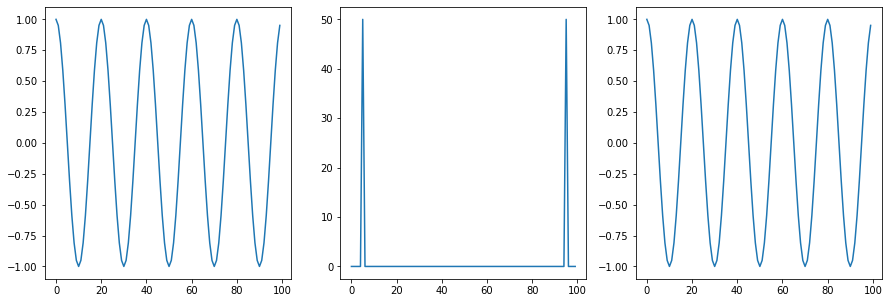

In [10]:
n = 100
f = 5
plt.subplot(1, 3, 1)
plt.plot(gimme_cos(n, f))

plt.subplot(1, 3, 2)
plt.plot(np.abs(np.fft.fft(gimme_cos(n, f))))

plt.subplot(1, 3, 3)
plt.plot(np.fft.ifft(np.fft.fft(gimme_cos(n, f))))

plt.gcf().set_size_inches(15, 5)